In [28]:
import torch
import torch.nn as nn

# Set the device (CPU or GPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Generator class
class Generator(nn.Module):
    def __init__(self, nz=128, channels=3):
        super(Generator, self).__init__()
        
        # Initialize input and output channels
        self.nz = nz
        self.channels = channels
        
        # Define a helper function to create a convolutional layer
        def convlayer(n_input, n_output, k_size=4, stride=2, padding=0):
            block = [
                nn.ConvTranspose2d(n_input, n_output, kernel_size=k_size, stride=stride, padding=padding, bias=False),
                nn.BatchNorm2d(n_output),
                nn.ReLU(inplace=True),
            ]
            return block

        # Build the model
        self.model = nn.Sequential(
            *convlayer(self.nz, 1024, 4, 1, 0), # First layer: Fully connected layer achieved through convolution.
            *convlayer(1024, 512, 4, 2, 1),    # Second layer
            *convlayer(512, 256, 4, 2, 1),     # Third layer
            *convlayer(256, 128, 4, 2, 1),     # Fourth layer
            *convlayer(128, 64, 4, 2, 1),      # Fifth layer
            nn.ConvTranspose2d(64, self.channels, 3, 1, 1), # Final layer to produce output with desired number of channels
            nn.Tanh() # Tanh activation function for the output
        )

    # Forward pass through the generator
    def forward(self, z):
        # Reshape input noise vector z to a batch of images
        z = z.view(-1, self.nz, 1, 1)
        img = self.model(z)
        return img

# Discriminator class
class Discriminator(nn.Module):
    def __init__(self, channels=3):
        super(Discriminator, self).__init__()
        
        # Initialize input channels
        self.channels = channels

        # Define a helper function to create a convolutional layer
        def convlayer(n_input, n_output, k_size=4, stride=2, padding=0, bn=False):
            block = [nn.Conv2d(n_input, n_output, kernel_size=k_size, stride=stride, padding=padding, bias=False)]
            if bn:
                block.append(nn.BatchNorm2d(n_output))
            block.append(nn.LeakyReLU(0.2, inplace=True))
            return block

        # Build the model
        self.model = nn.Sequential(
            *convlayer(self.channels, 32, 4, 2, 1),  # First layer
            *convlayer(32, 64, 4, 2, 1),             # Second layer
            *convlayer(64, 128, 4, 2, 1, bn=True),   # Third layer with batch normalization
            *convlayer(128, 256, 4, 2, 1, bn=True),  # Fourth layer with batch normalization
            nn.Conv2d(256, 1, 4, 1, 0, bias=False),  # Final layer: Fully connected layer through convolution
        )

    # Forward pass through the discriminator
    def forward(self, imgs):
        # Pass the images through the model
        out = self.model(imgs)
        # Flatten the output
        return out.view(-1, 1)

In [33]:
import torch
def generate_images(model_path):
    # from your_model_module import Generator  # Replace with the actual module where your Generator class is defined

    # Instantiate the Generator model
    # Set the device (CPU or GPU)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    generator = Generator(nz=30, channels=3).to(device)

    # Load the state dict from the .pth file
    checkpoint = torch.load(model_path)

    # Load the state dict into the generator model
    generator.load_state_dict(checkpoint)

    # Set the model to evaluation mode
    generator.eval()

    # Generate random noise vector
    batch_size = 32  # Set the number of images to generate
    nz = 30  # Set the latent dimensions
    noise = torch.randn(batch_size, nz, 1, 1, device=device)

    gen_images = (generator(noise).to("cpu").clone().detach() + 1) / 2
    # 'netG(gen_z)' passes the noise vectors through the generator to produce a batch of images.
    # '.to("cpu")' moves the generated images to the CPU. This is necessary for converting them into numpy arrays later.
    # '.clone().detach()' creates a copy of the images and detaches them from the current computation graph.
    # '(... + 1) / 2' rescales the pixel values from the range [-1, 1] to [0, 1].
    # This rescaling is necessary because the generator often uses Tanh activation in the output layer, resulting in outputs in the range [-1, 1].

    # Convert the images to numpy arrays for visualization
    gen_images = gen_images.numpy().transpose(0, 2, 3, 1)  
    # '.numpy()' converts the tensor of generated images to a numpy array.
    # '.transpose(0, 2, 3, 1)' changes the shape of the array from [batch, channels, height, width] to [batch, height, width, channels].
    # This transposition is required for visualization purposes, as most visualization libraries expect the channel dimension to be last.

    # Create a figure for plotting the images
    fig = plt.figure(figsize=(25, 16))  
    # 'figsize=(25, 16)' sets the size of the figure to 25 inches wide and 16 inches tall.
    # This large size helps in better visualization of multiple images.

    # Loop through the generated images
    for ii, img in enumerate(gen_images):
        # Add a subplot for each image in the figure
        ax = fig.add_subplot(4, 8, ii + 1, xticks=[], yticks=[])  
        # '4, 8' means the grid will have 4 rows and 8 columns.
        # 'ii + 1' is the position of the subplot in the grid.
        # 'xticks=[]' and 'yticks=[]' remove the x and y axis tick marks for each subplot.

        # Display the image in the subplot
        plt.imshow(img)  
        # 'plt.imshow' displays the image. 'img' is the current image in the loop.

    # Show the complete figure with all subplots
    plt.show()


 Generating Image for 0 epochs training


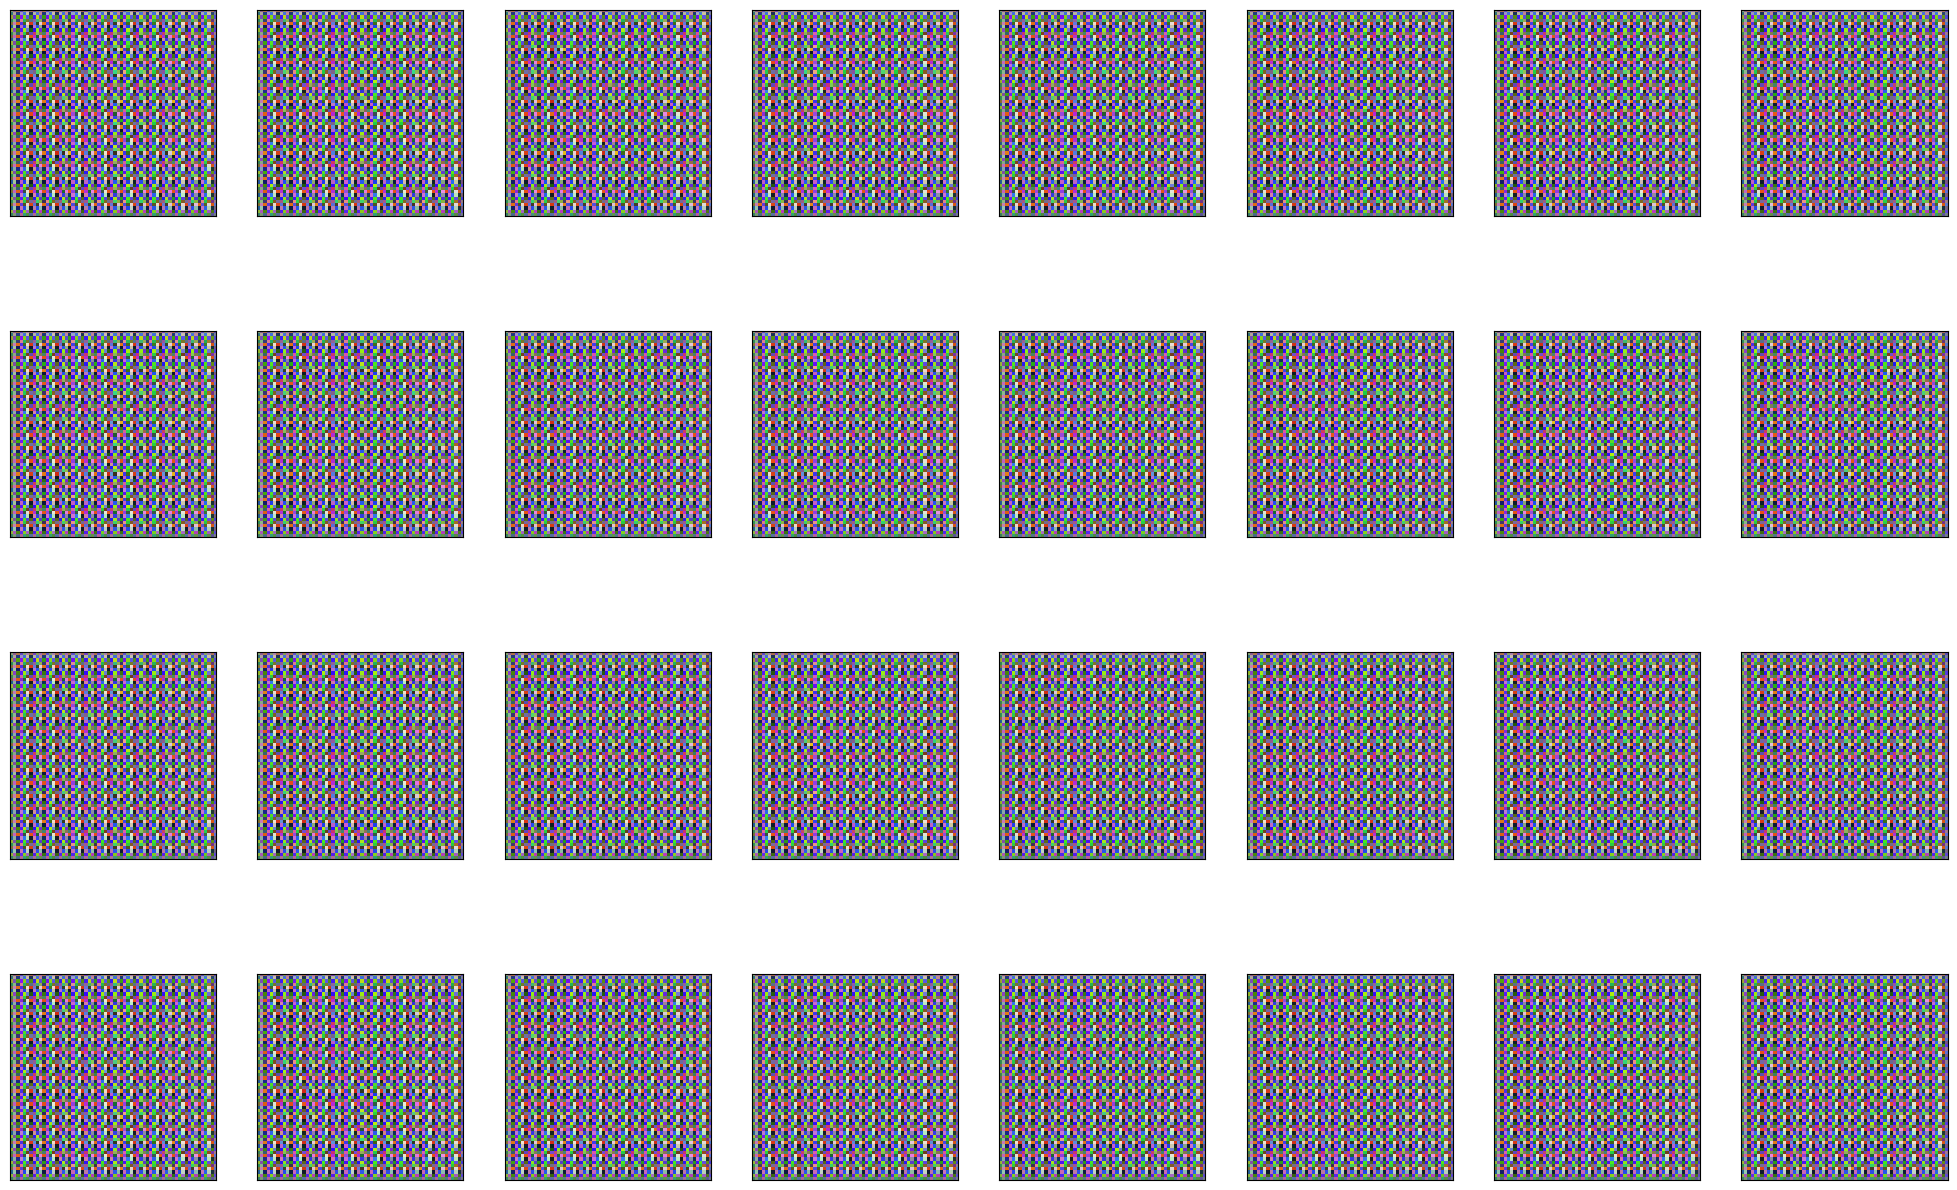


 Generating Image for 100 epochs training


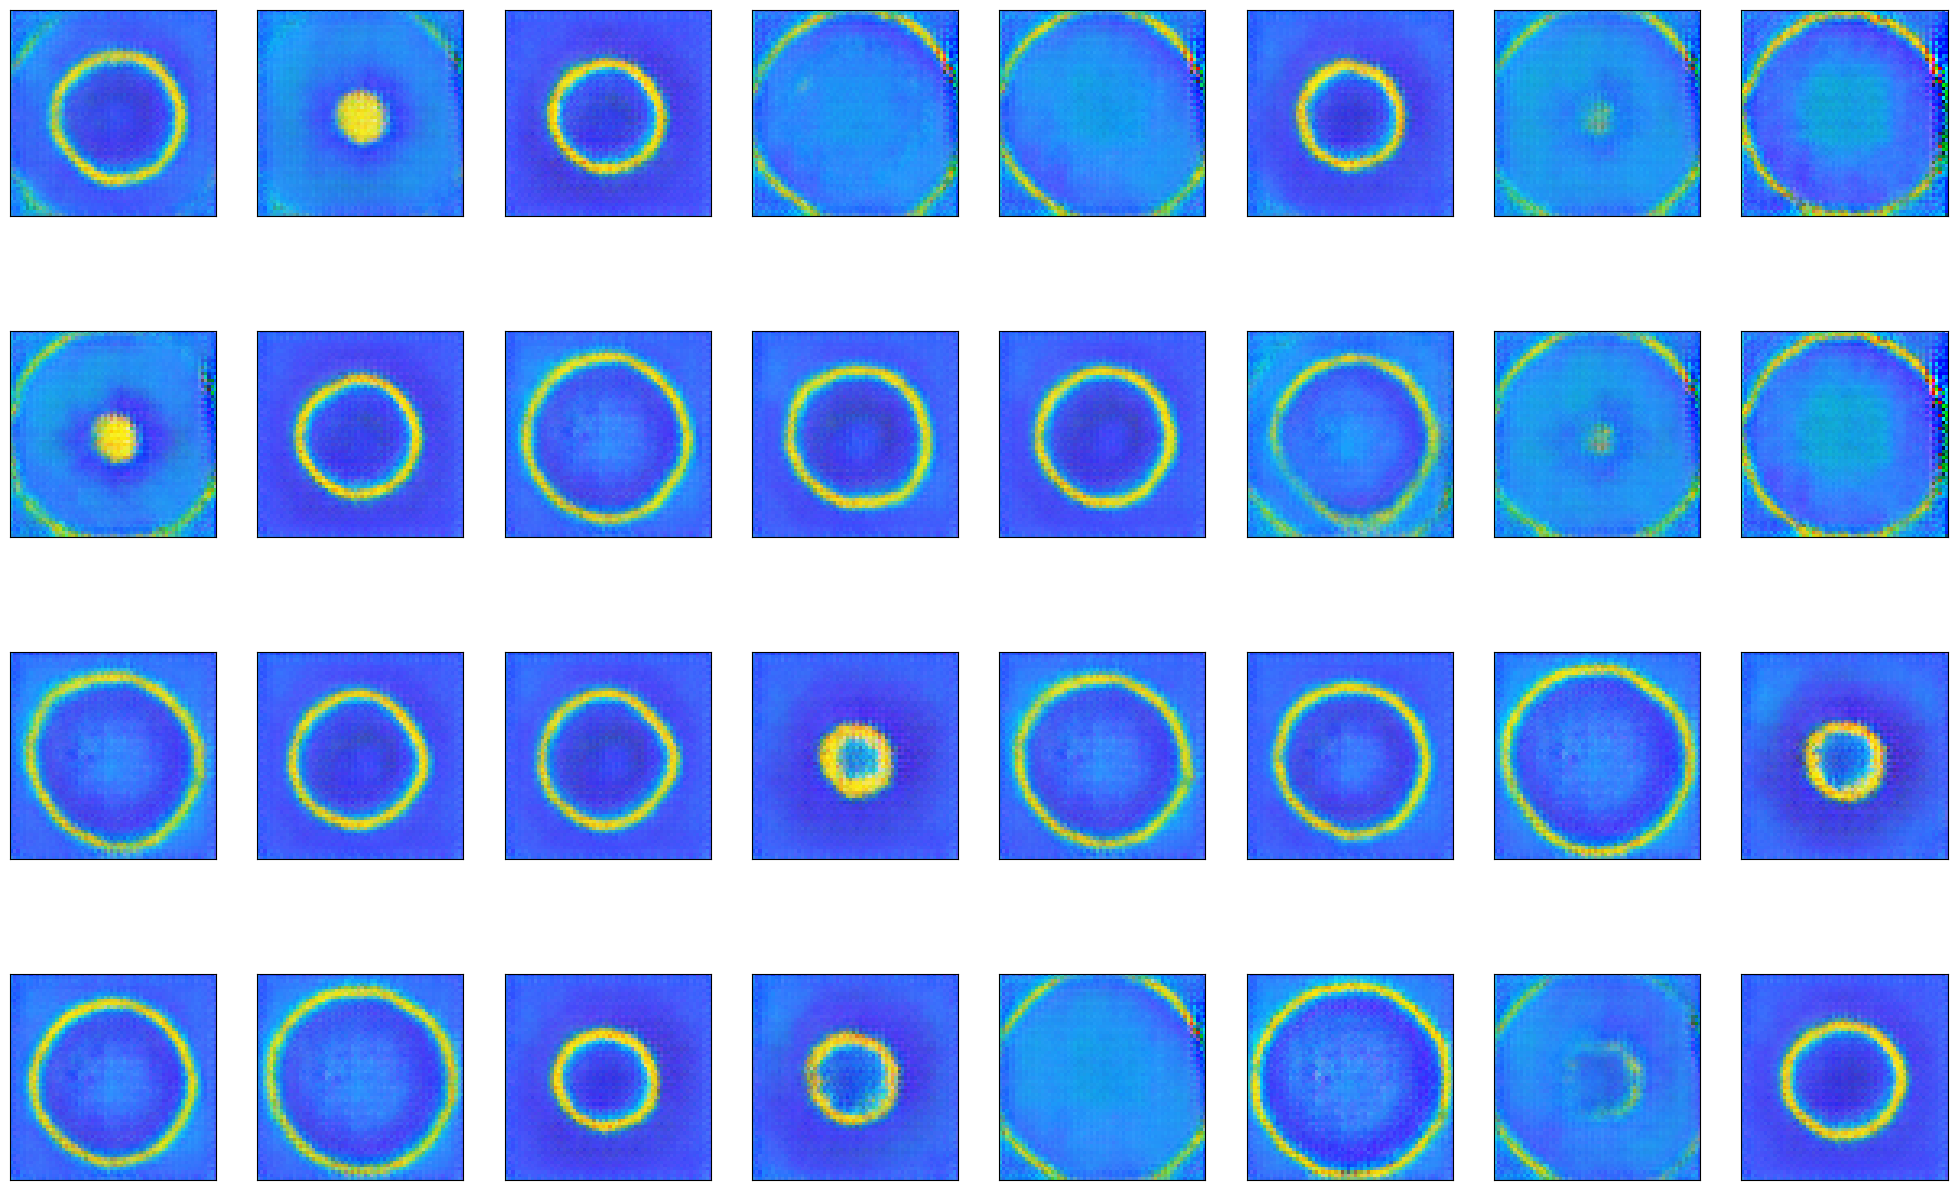


 Generating Image for 200 epochs training


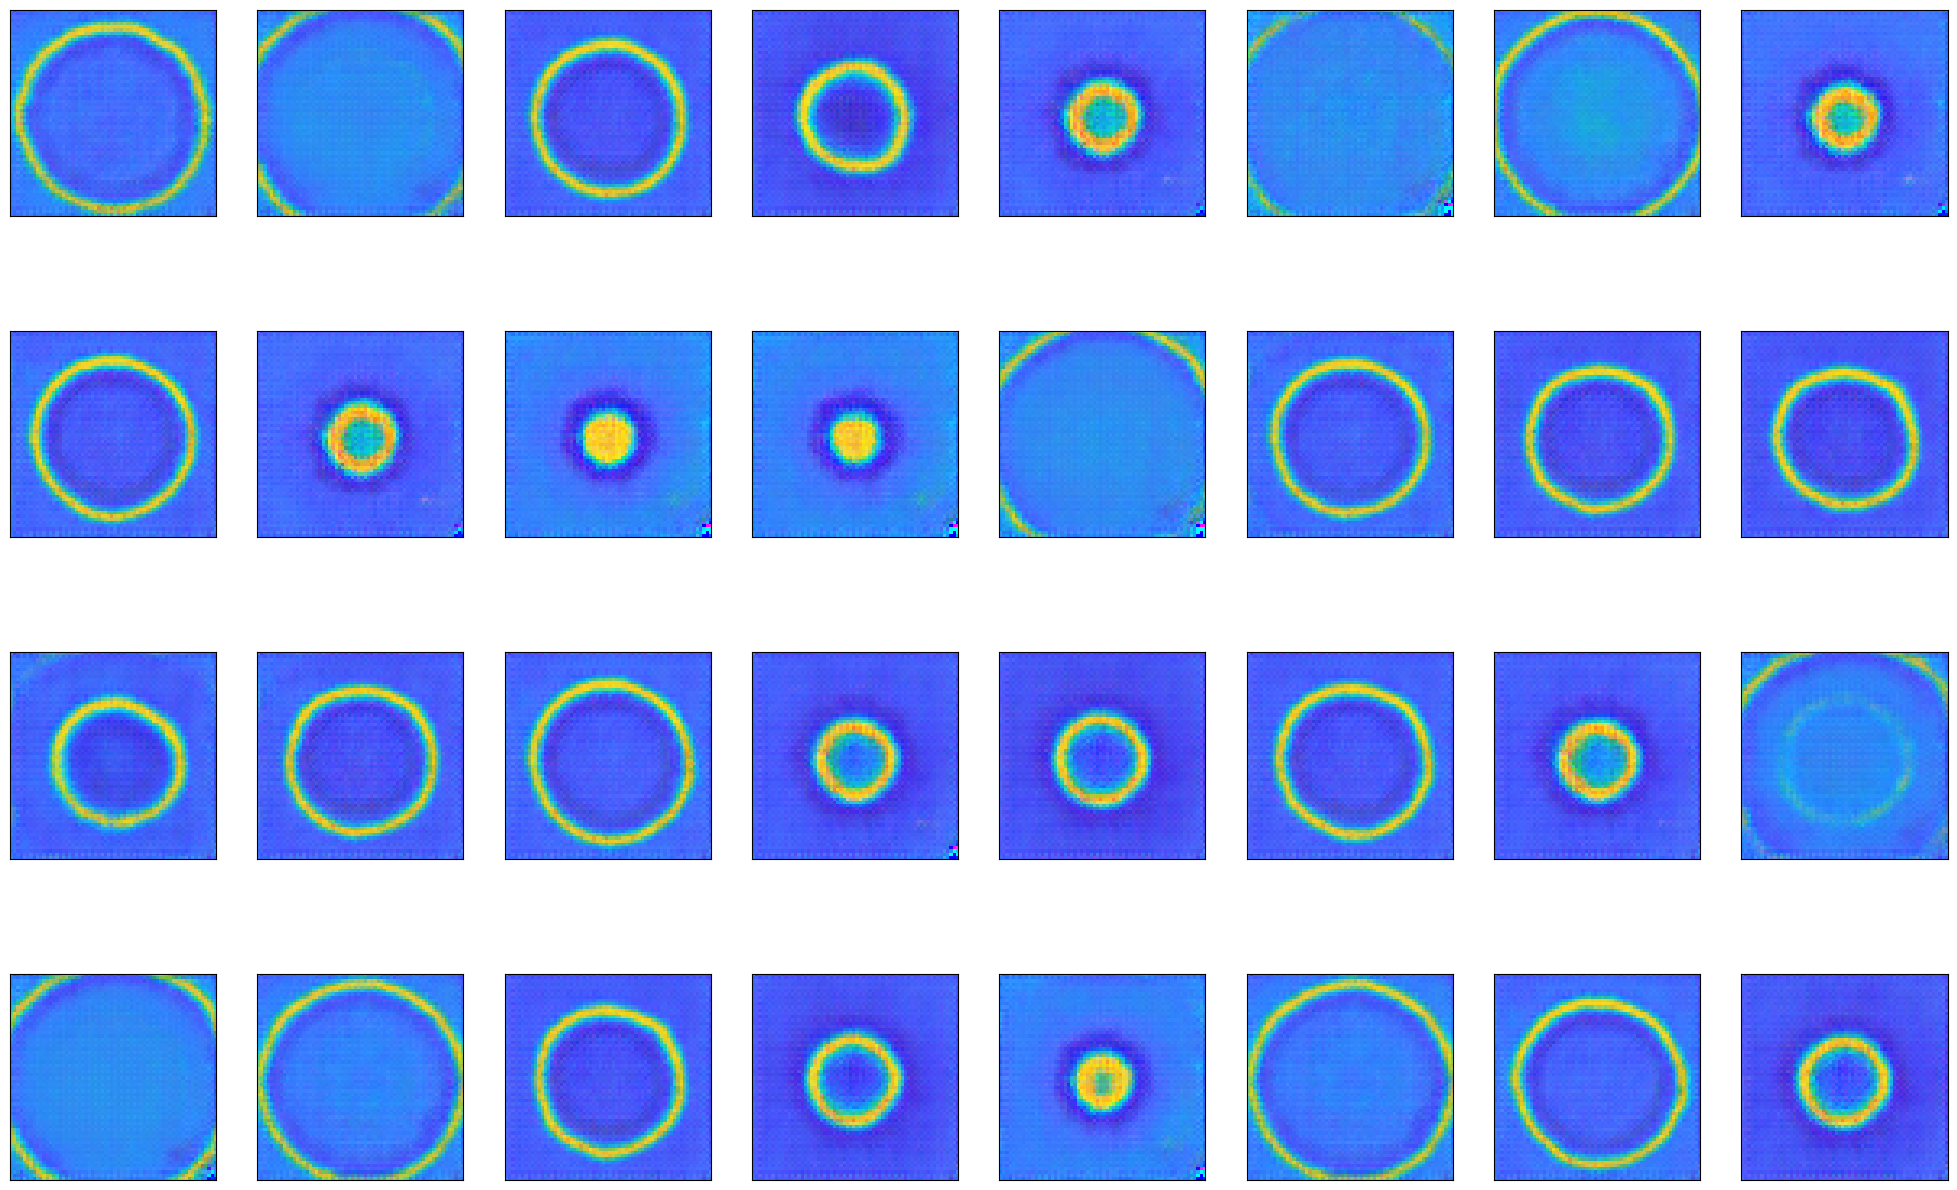


 Generating Image for 300 epochs training


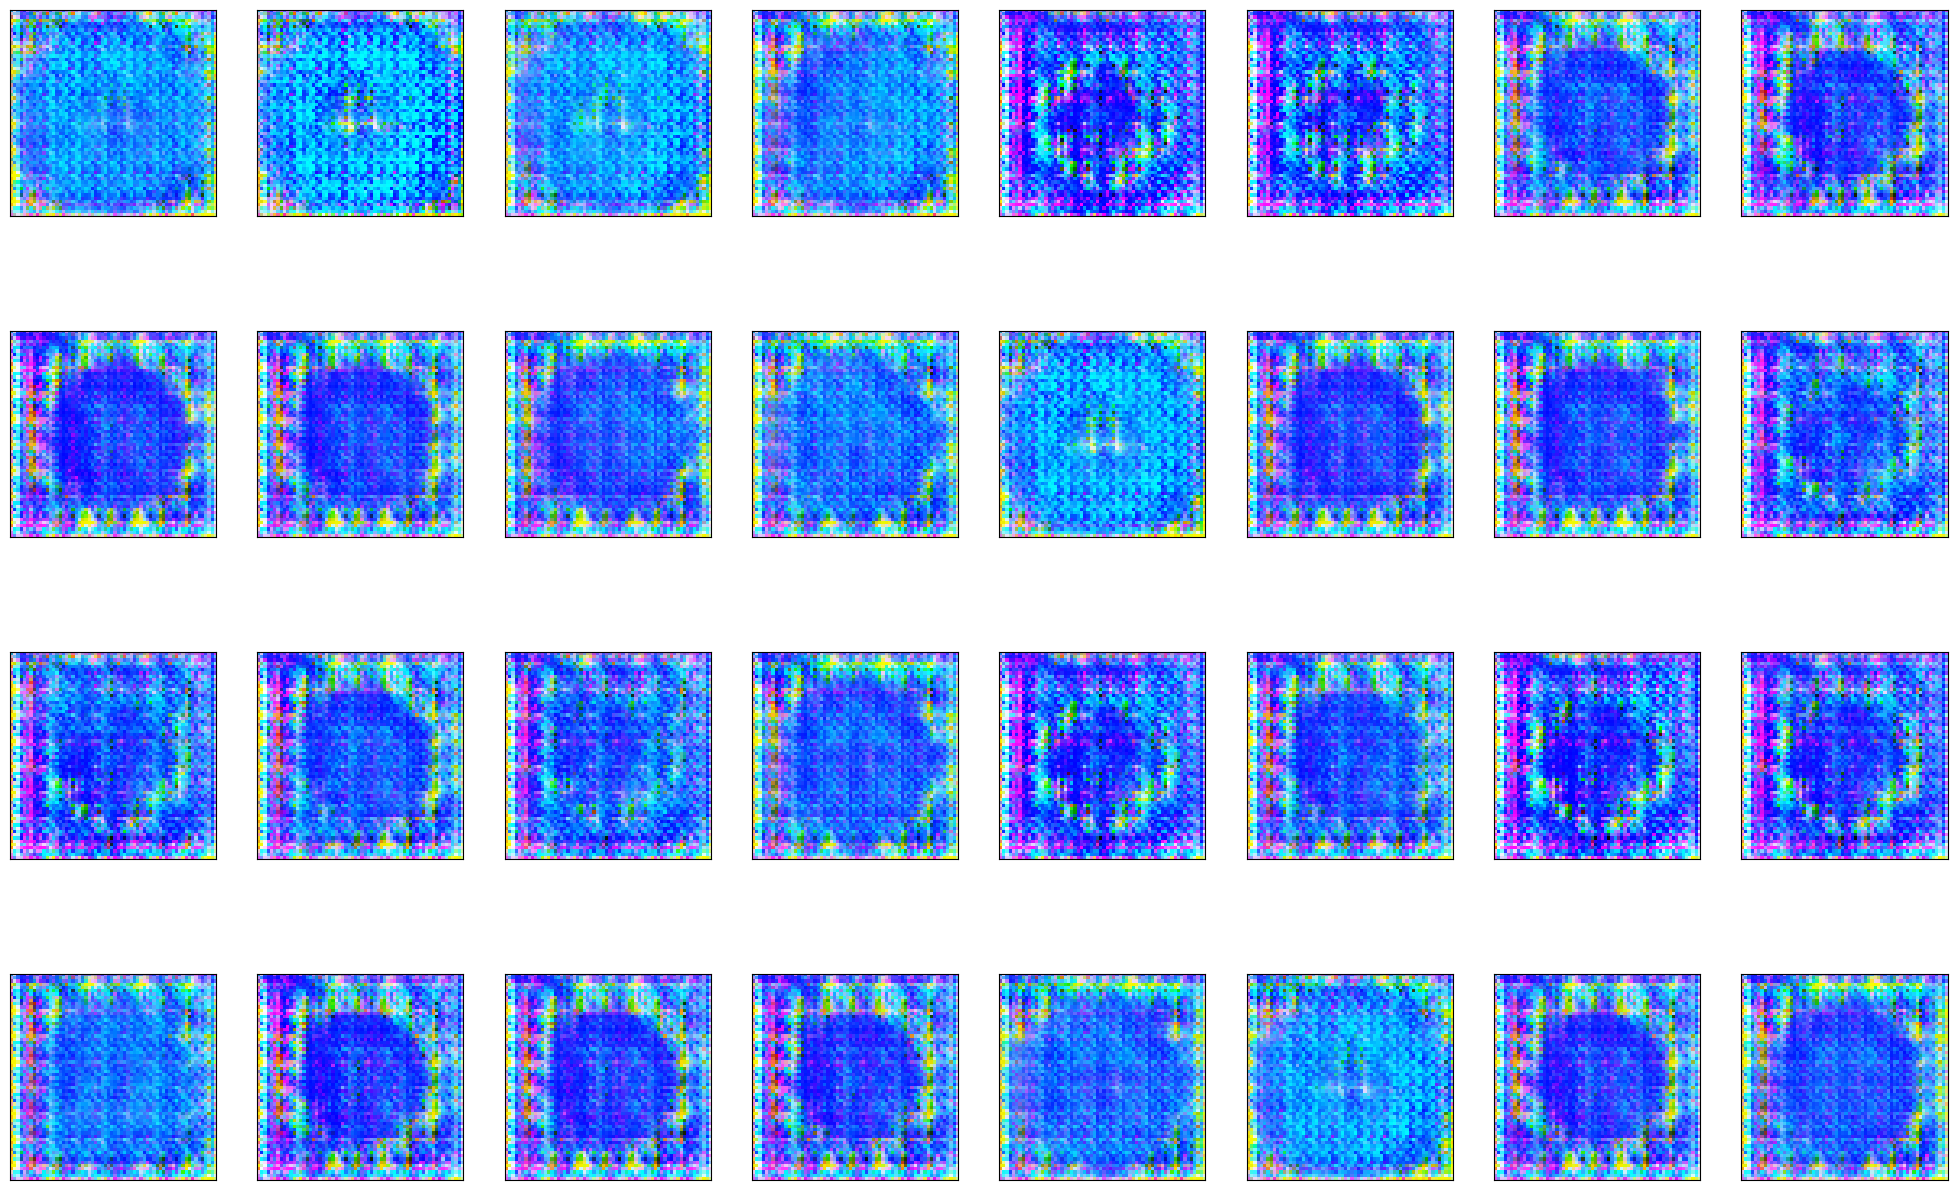


 Generating Image for 400 epochs training


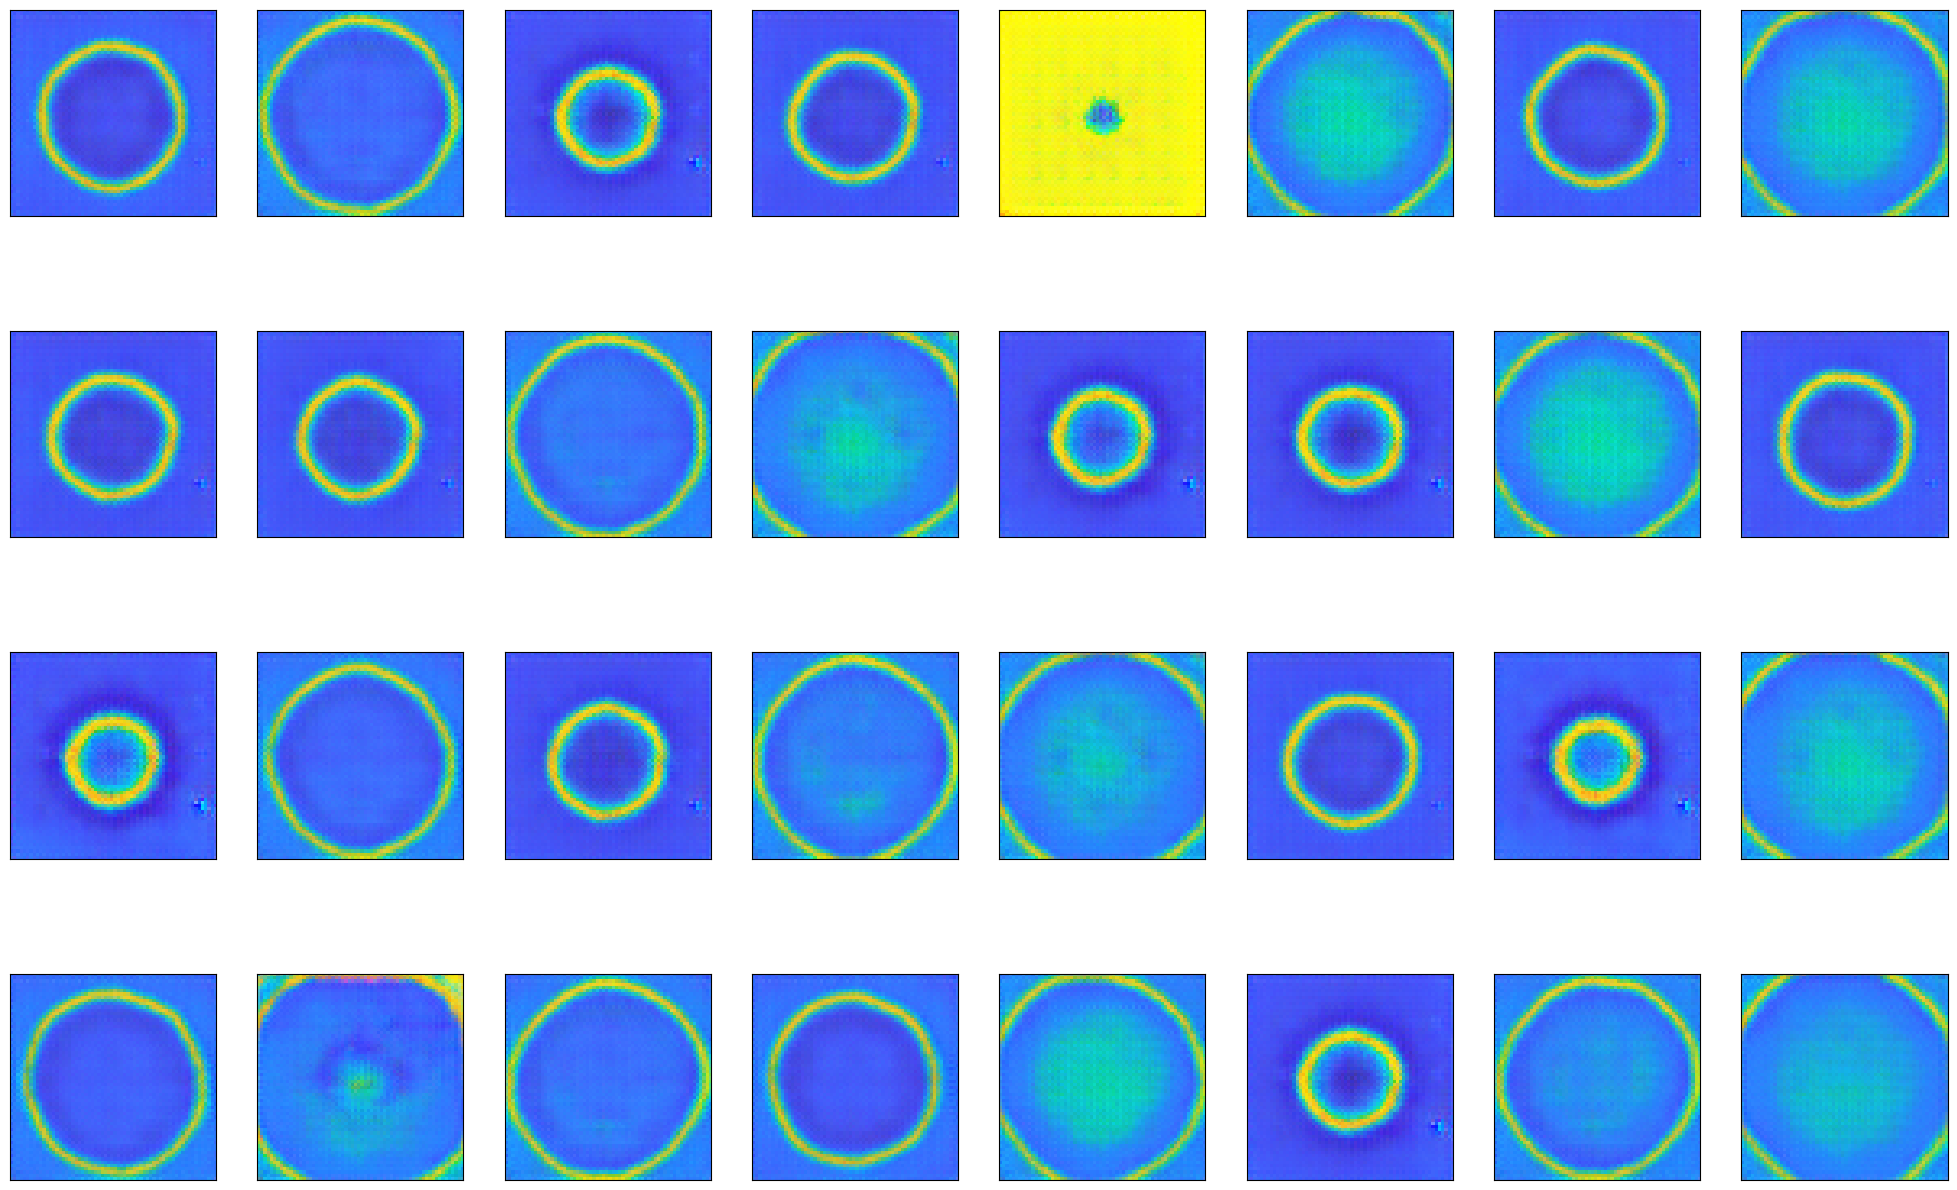


 Generating Image for 500 epochs training


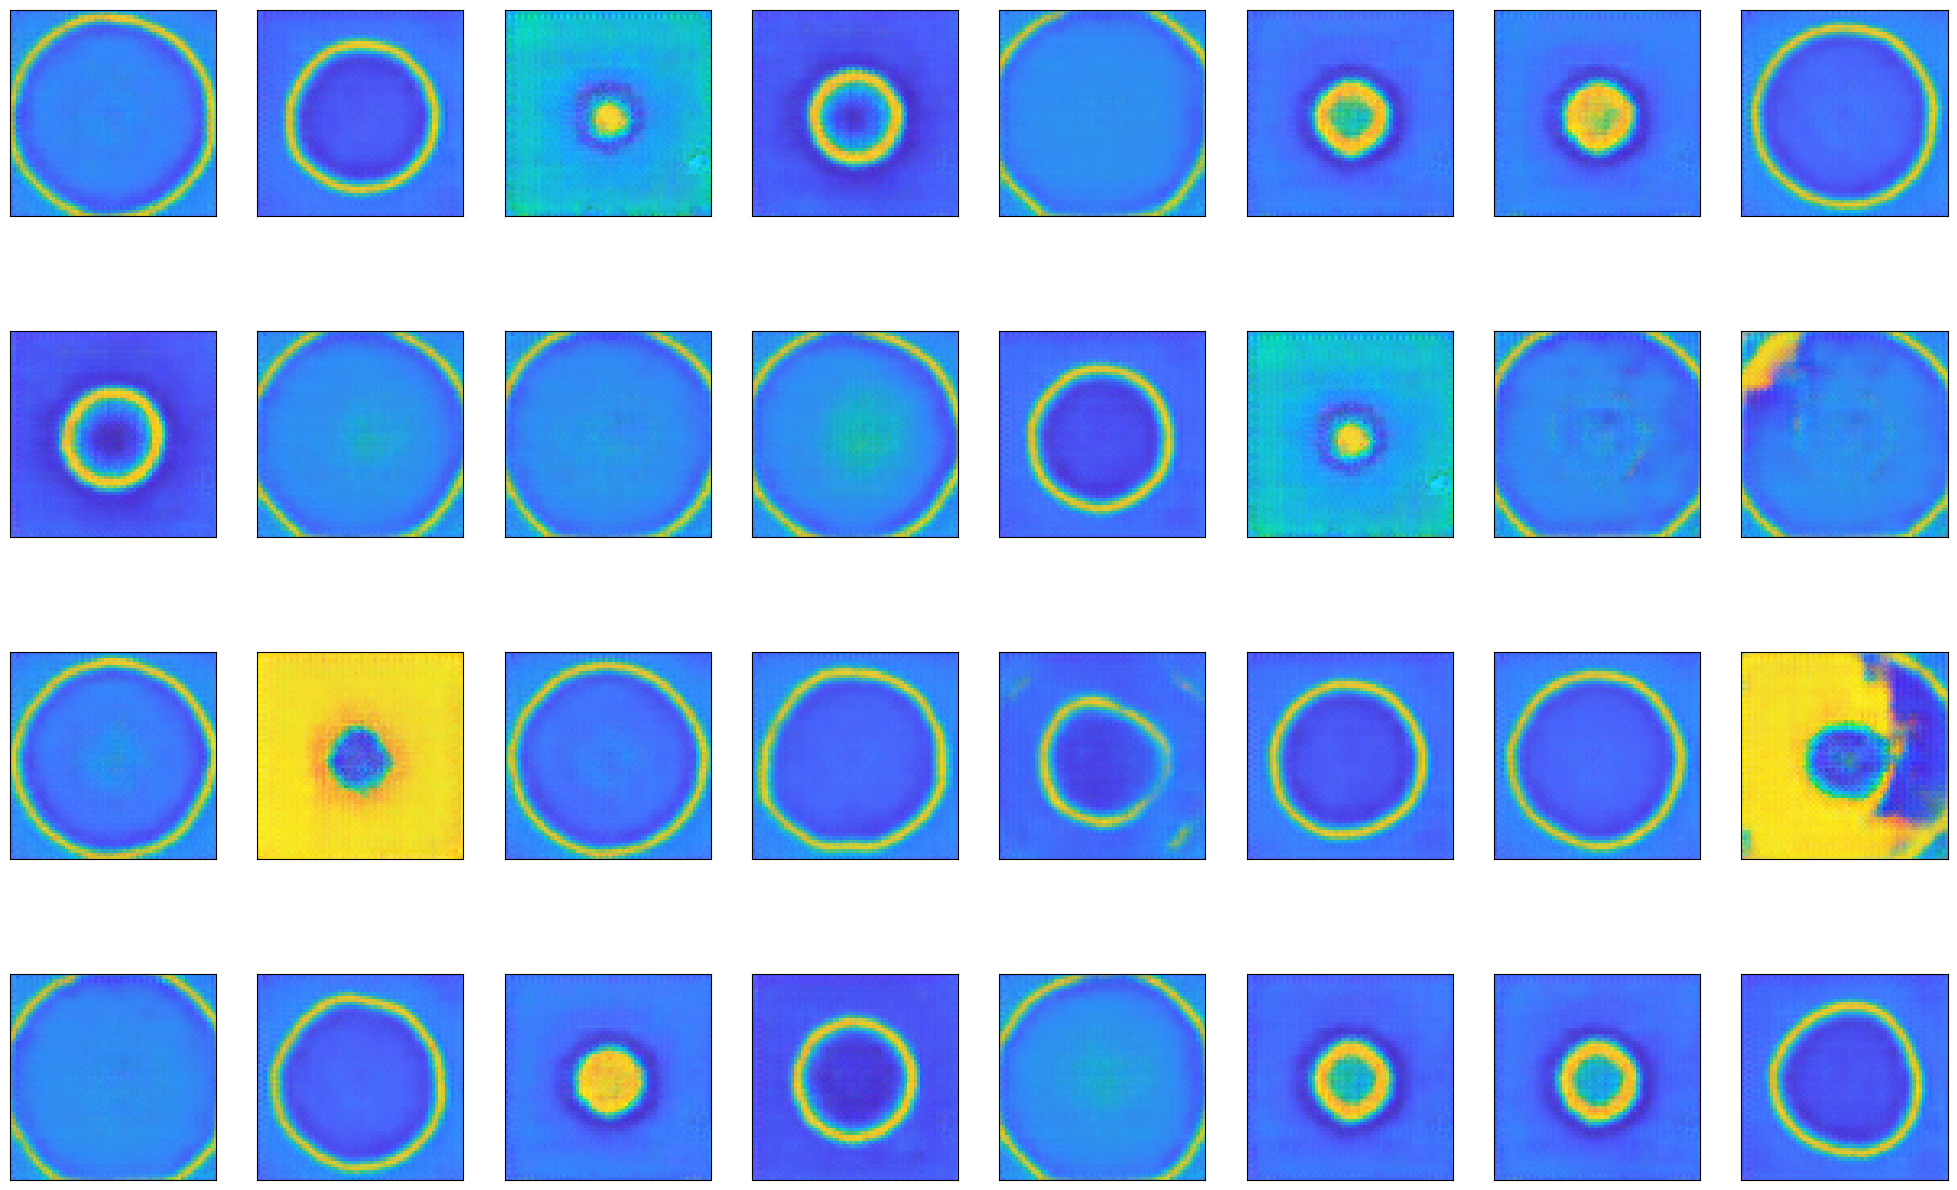


 Generating Image for 600 epochs training


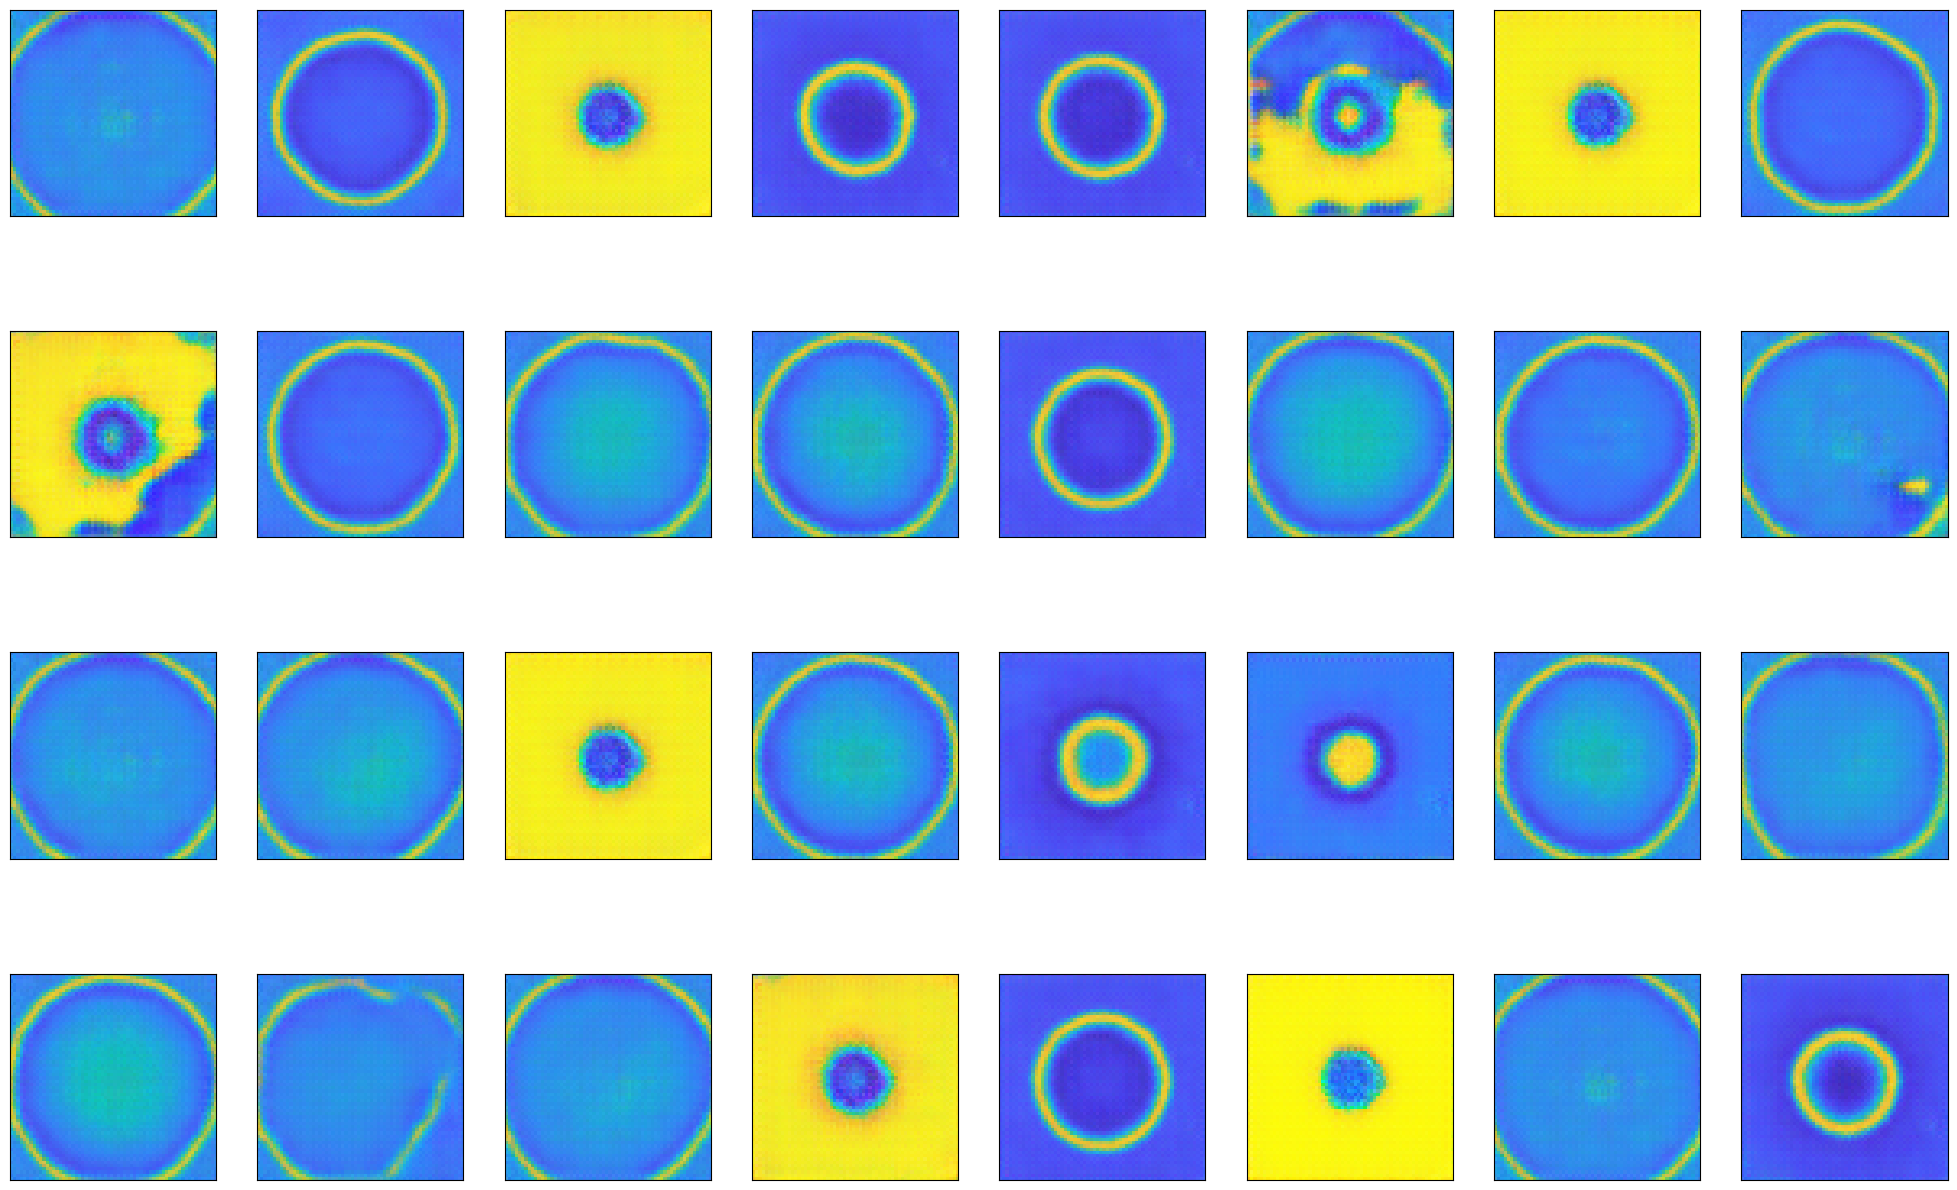


 Generating Image for 700 epochs training


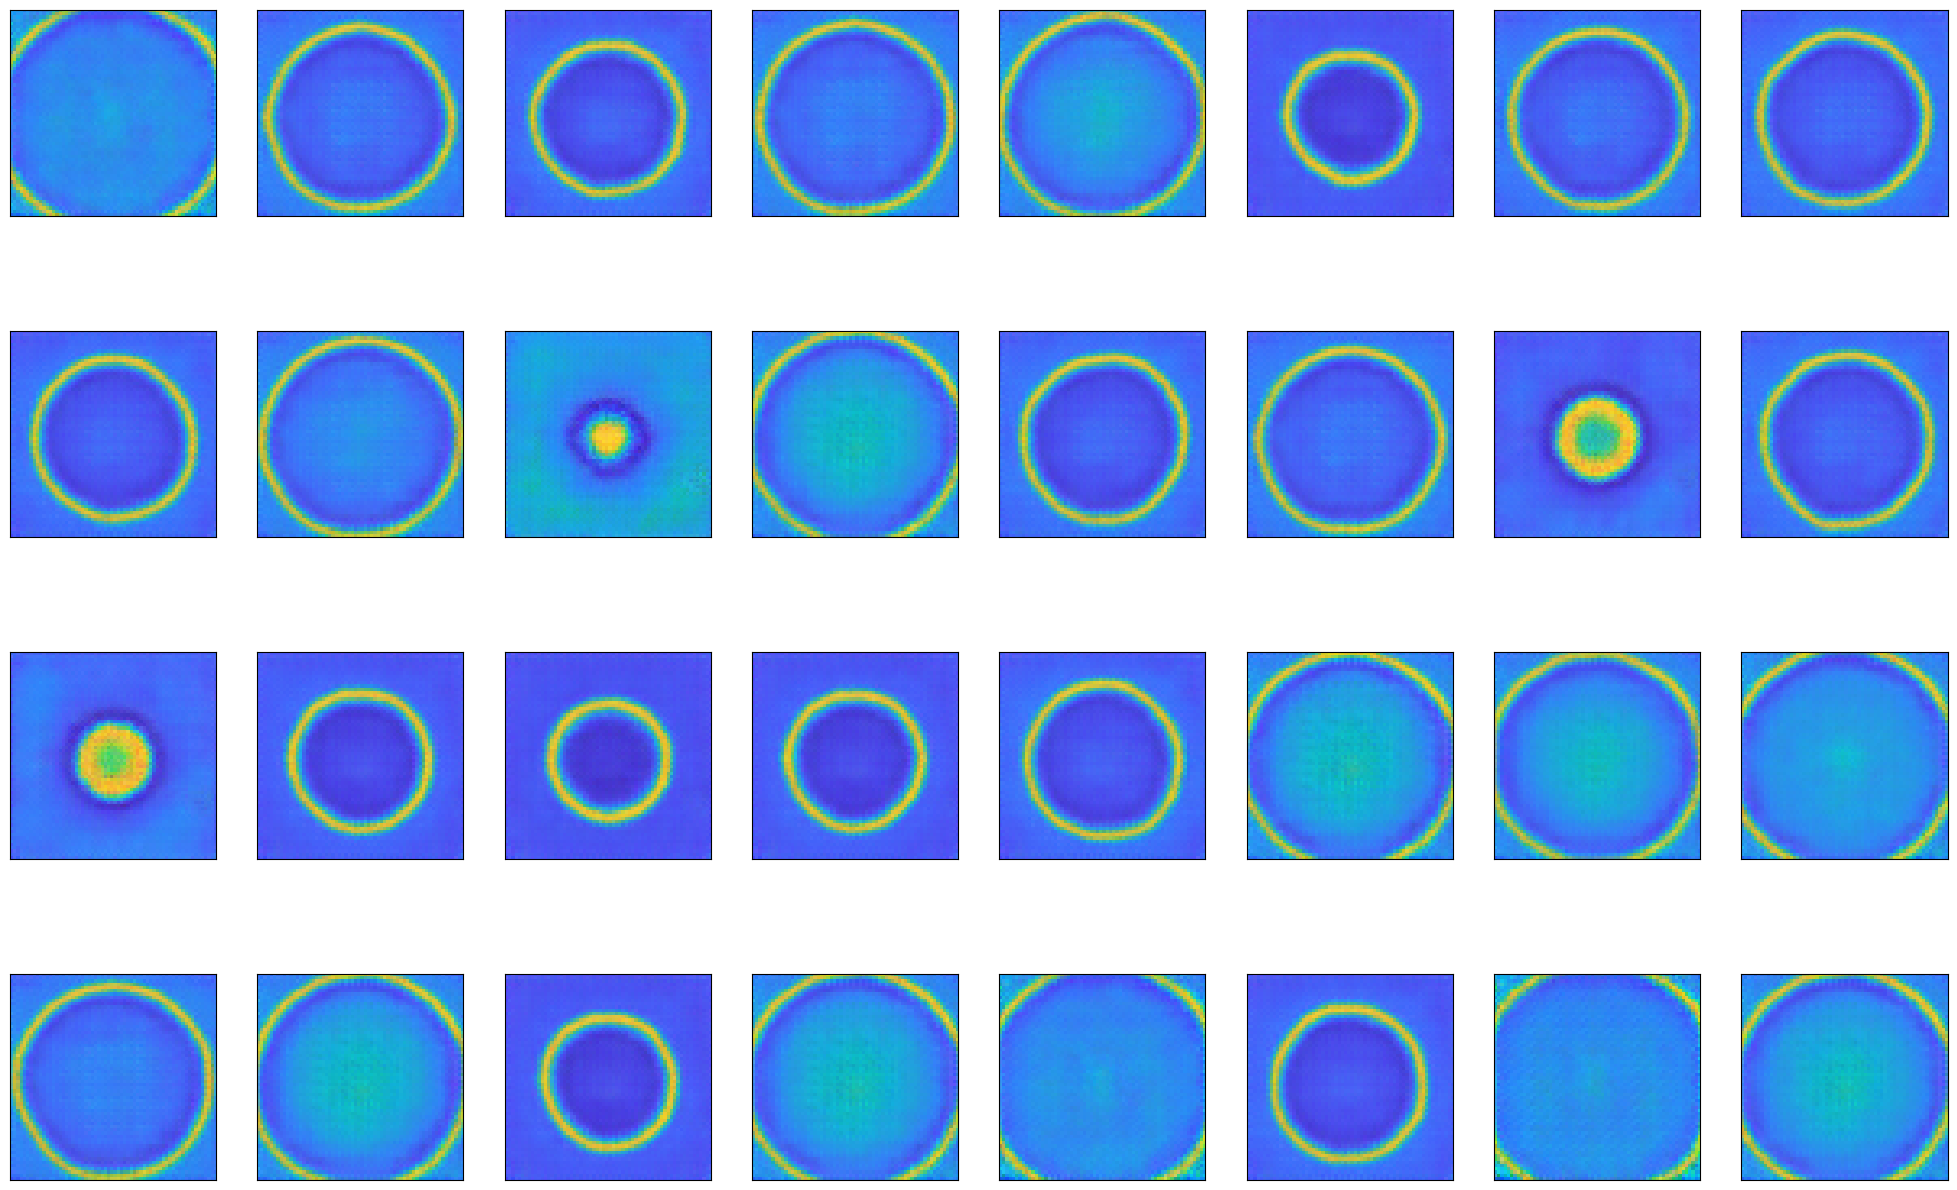


 Generating Image for 800 epochs training


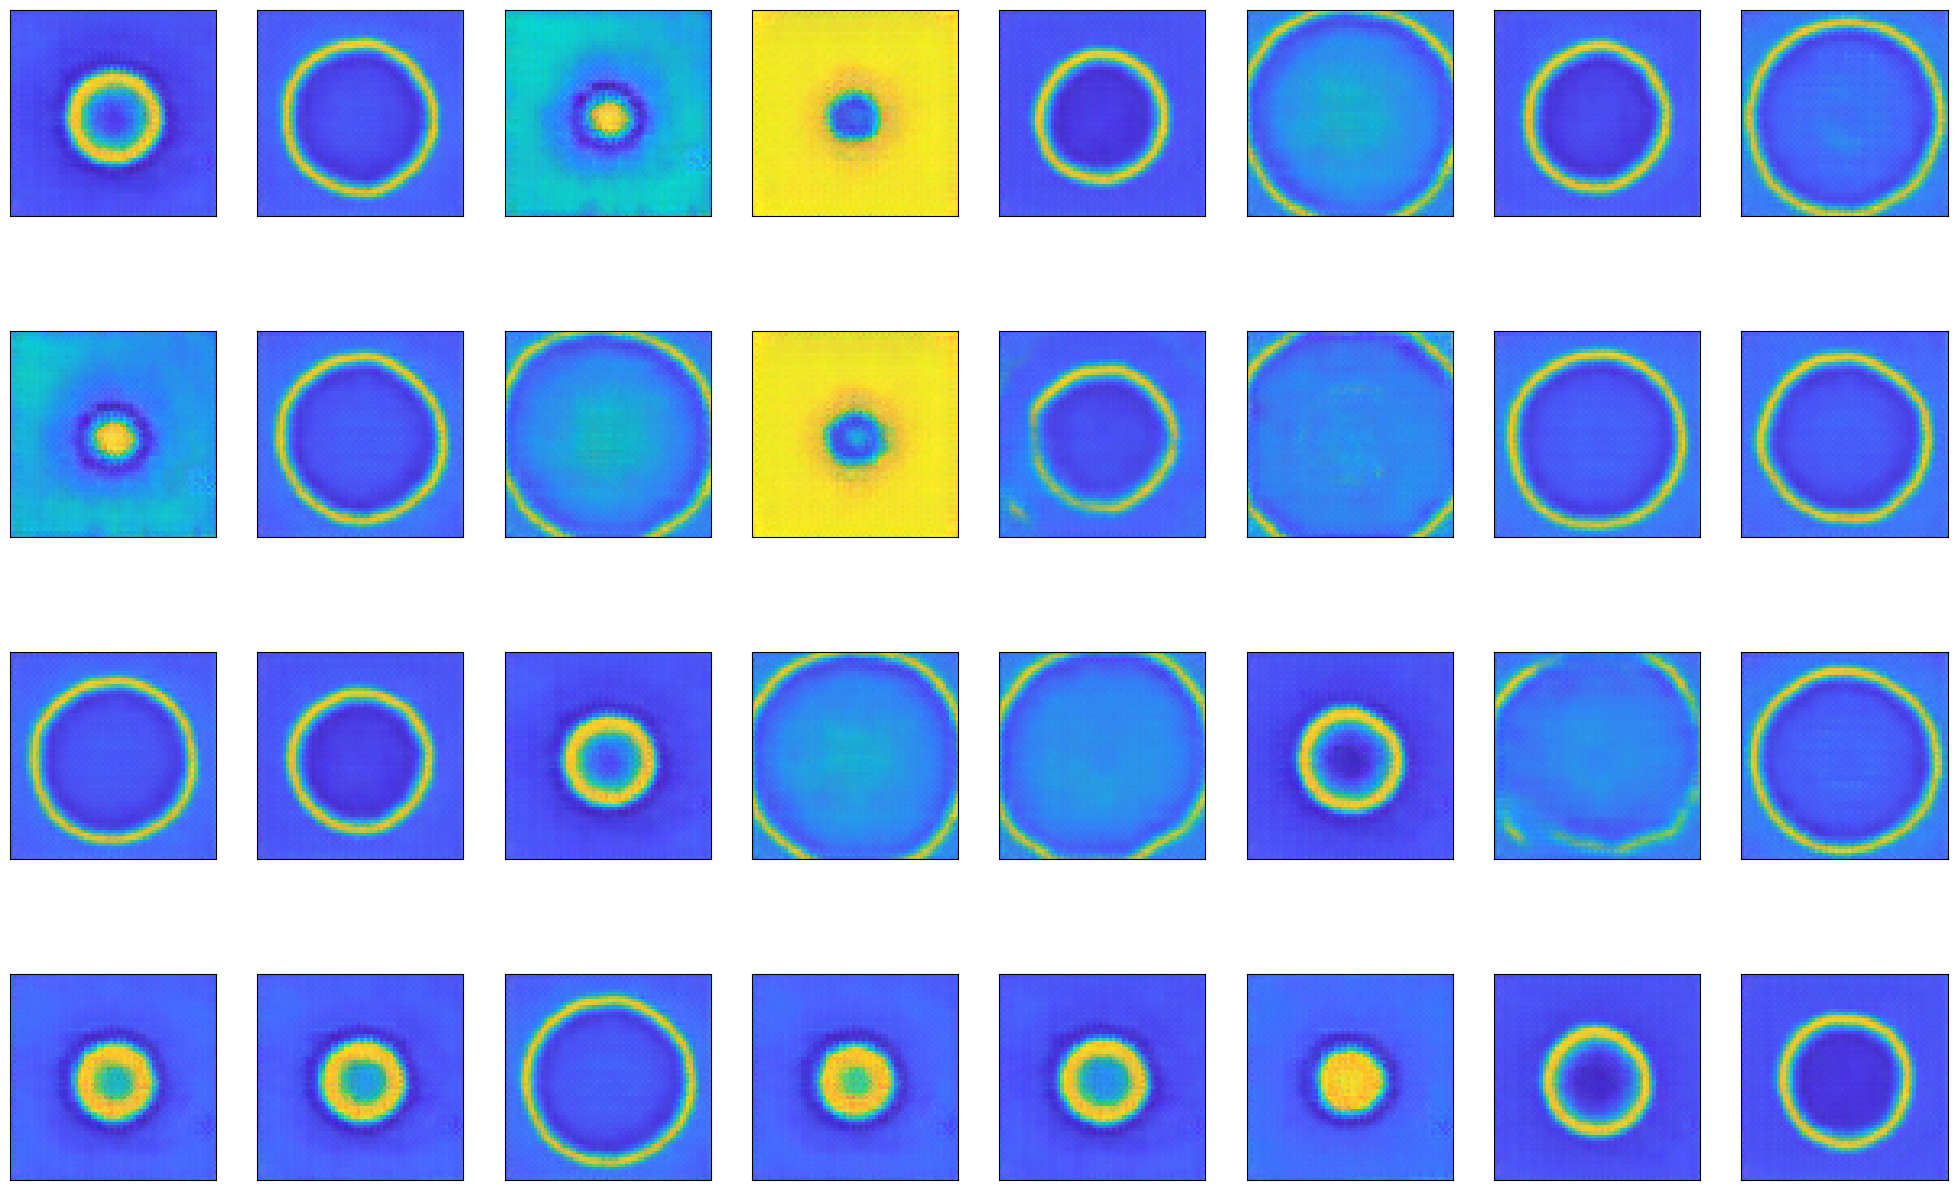


 Generating Image for 900 epochs training


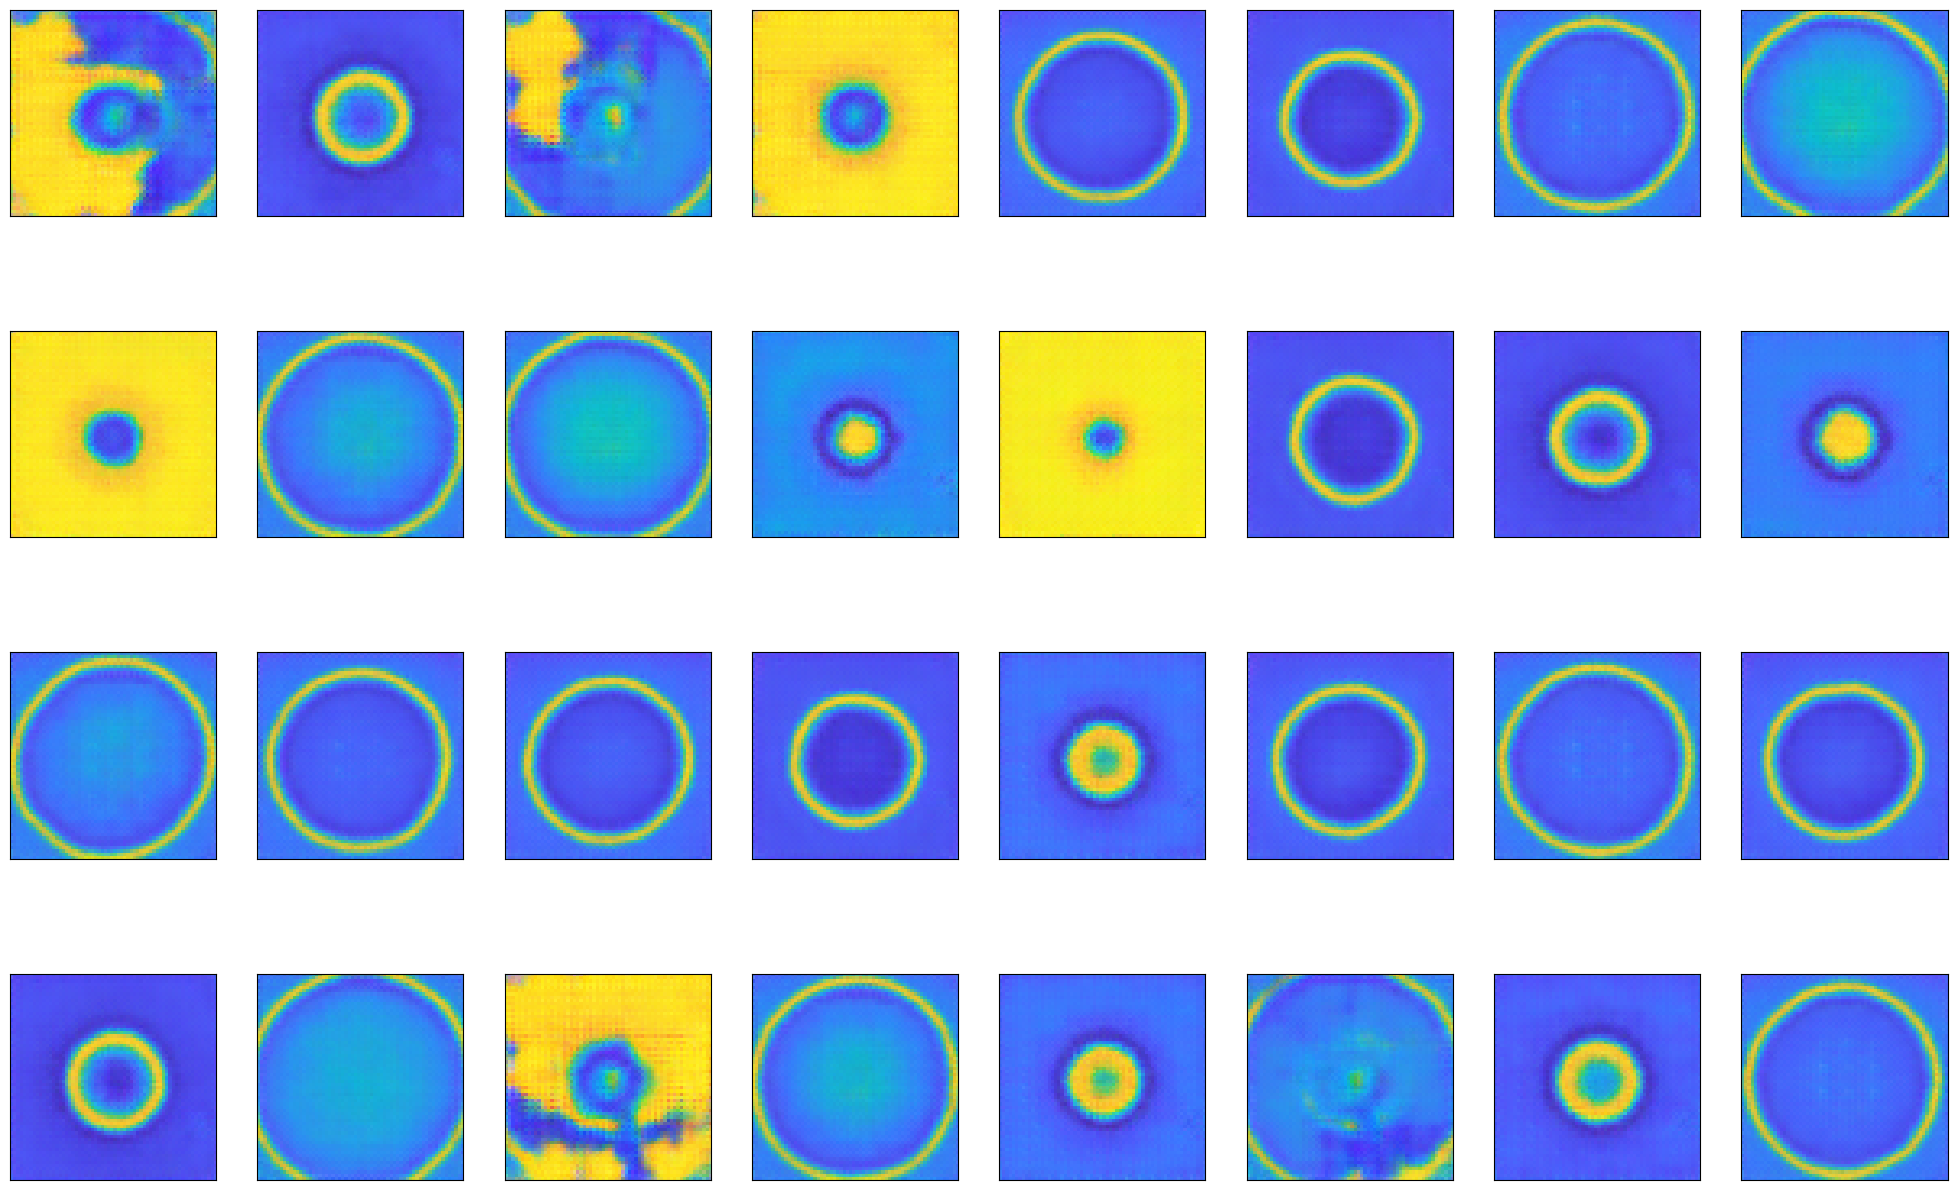


 Generating Image for 1000 epochs training


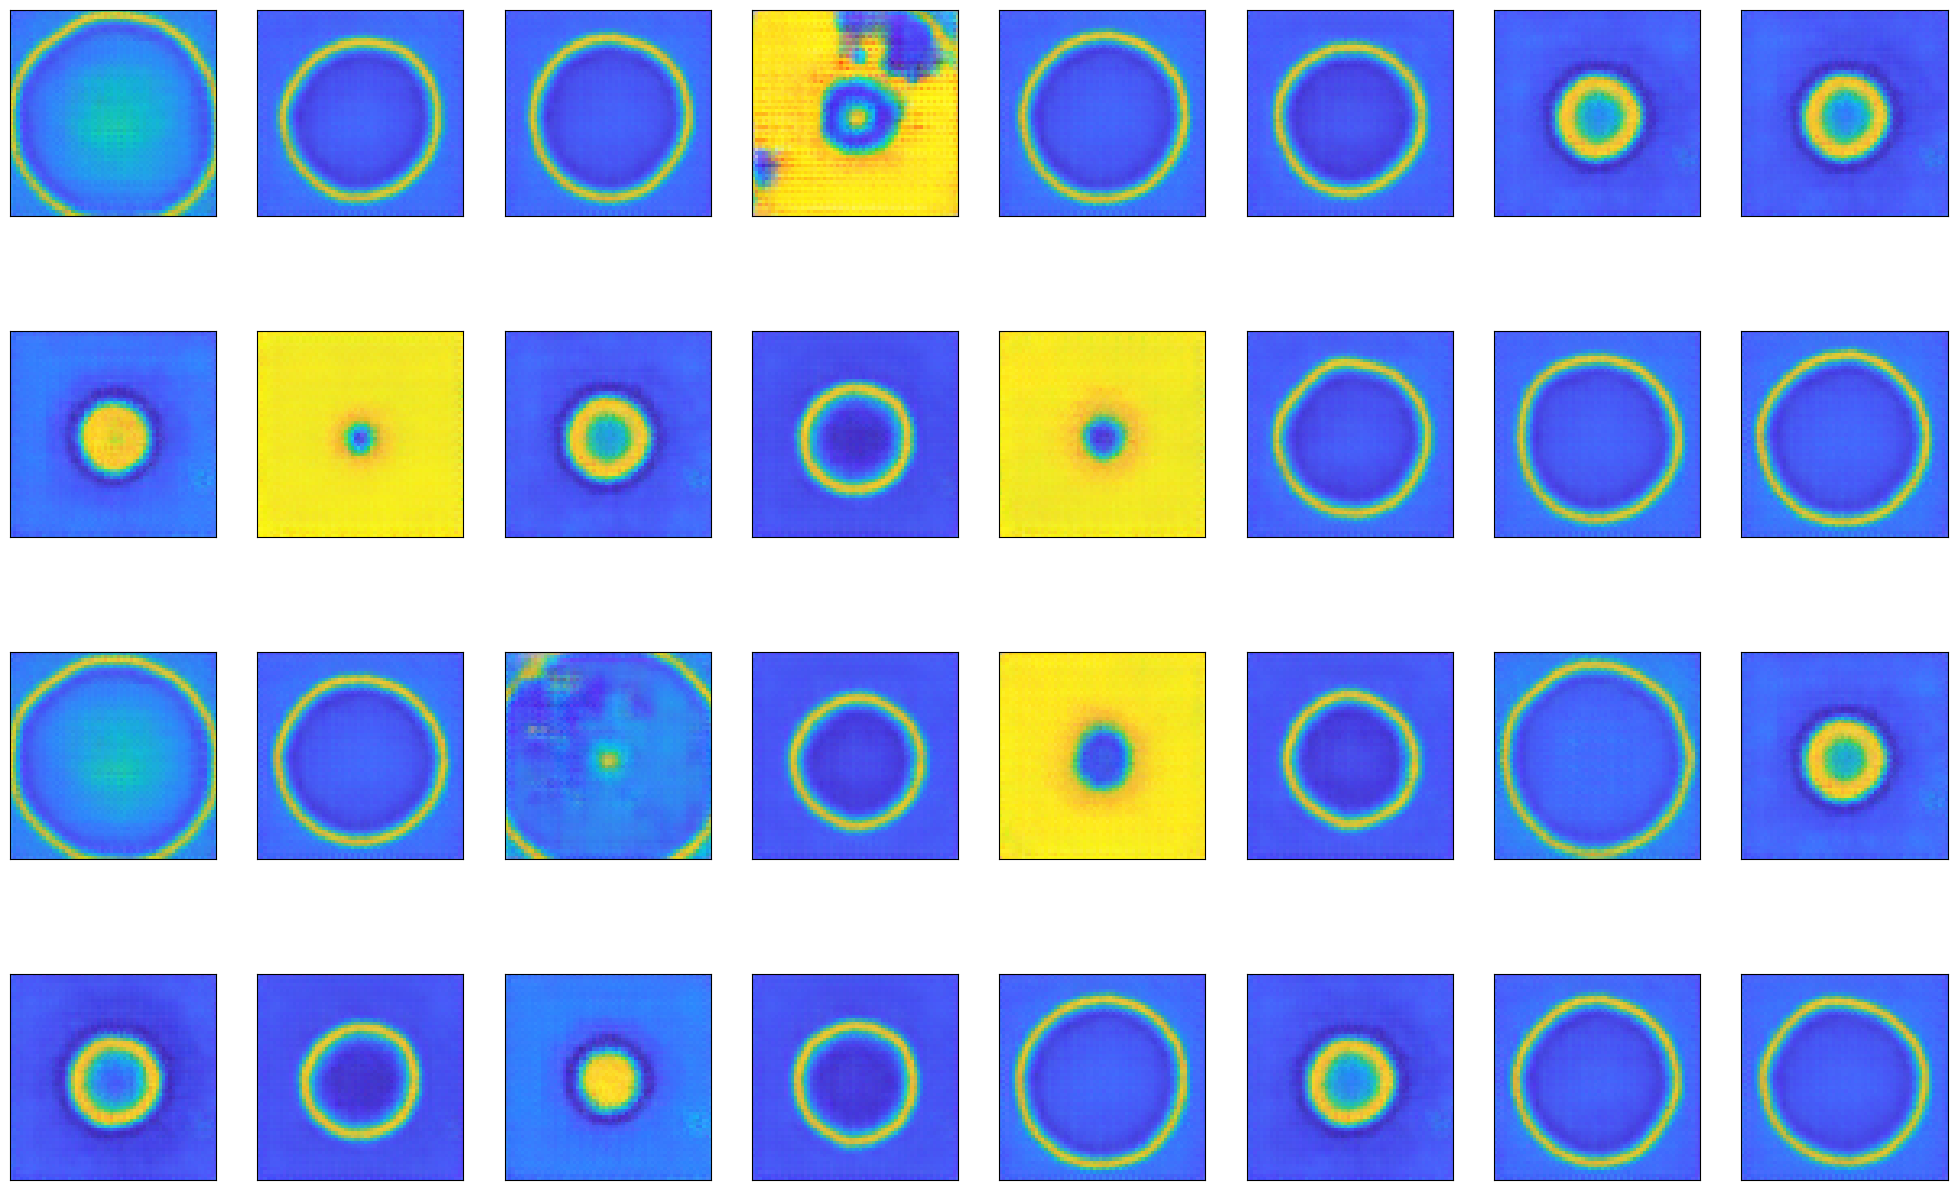

In [34]:
for i in range(0,1001,100):
    if(i == 1000):
        model_path = '/kaggle/input/dcgans-epoch-test/generator_ben__0.001_13_1000_30.pth'
    else:
        model_path = f'/kaggle/input/dcgans-epoch-test/generator_ben_{i}.pth'
    print(f'\n Generating Image for {i} epochs training')
    generate_images(model_path)